# __Laboratorium__
***

### Konfiguracja

In [47]:
%matplotlib notebook
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import pandas as pd
from copy import copy
import matplotlib.colors as col
from IPython.display import display


# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [48]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# __Rozwiązanie__
***

In [49]:
# Implementacja współczynników macierzy

def det3x3(a, b, c):
    return (a[0]*b[1]) + (a[1]*c[0]) + (b[0]*c[1])\
            - (c[0]*b[1]) - (b[0]*a[1]) - (a[0]*c[1])

def det2x2(a, b, c):
    return (a[0] - c[0])*(b[1] - c[1]) - (b[0] - c[0])*(a[1] - c[1])

## 1. Przygotowanie zbiorów punktów

In [50]:
# 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]
points_a = [(random.uniform(-1000, 1000), random.uniform(-1000, 1000)) for _ in range(10**5)]

# 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14]
points_b = [(random.uniform(-10**14, 10**14), random.uniform(-10**14, 10**14)) for _ in range(10**5)]

# 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100
points_c = [None for _ in range(1000)]
for i in range(1000):
    t = random.uniform(0, 2*np.pi)
    points_c[i] = (100*np.cos(t), 100*np.sin(t))
    
# 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej
# wyznaczonej przez wektor (a, b),
a = (-1, 0)
b = (1, 0.1)
A = (b[1] - a[1])/(b[0] - a[0]) # współczynnik kierunkowy prostej ab
B = a[1] - (A*a[0]) # współrzędna y przeciecia prostej z osią OY

points_d = [None for _ in range(1000)]
for i in range(1000):
    x = random.uniform(-1000, 1000)
    points_d[i] = (x, A*x + B)

## 2. Wizualizacja graficzna zbiorów punktów

<IPython.core.display.Javascript object>


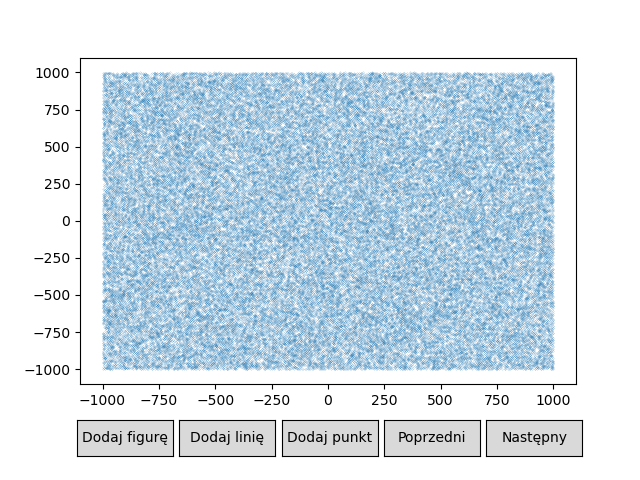

In [93]:
plot_a = Plot(points = [PointsCollection(points_a, s=.01)])
plot_a.draw()

<IPython.core.display.Javascript object>


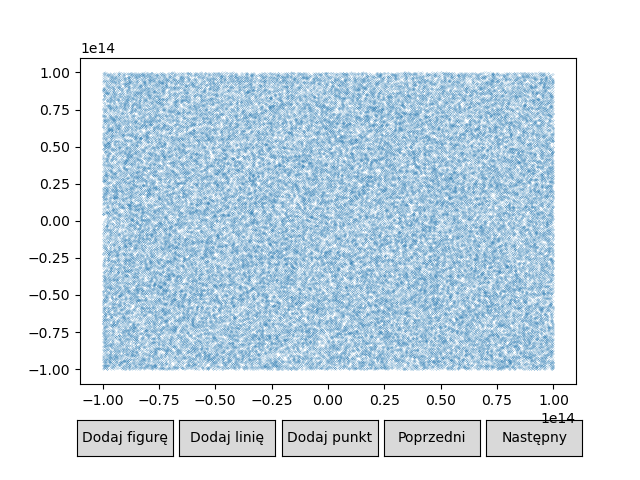

In [94]:
plot_b = Plot(points = [PointsCollection(points_b, s=.01)])
plot_b.draw()

<IPython.core.display.Javascript object>


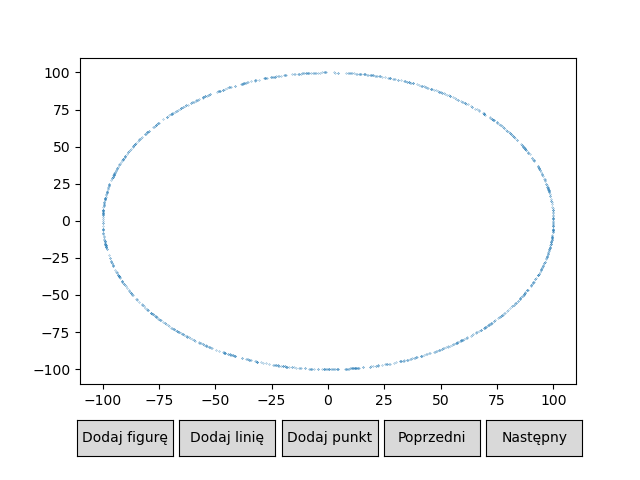

In [95]:
plot_c = Plot(points = [PointsCollection(points_c, s=0.05)])
plot_c.draw()

<IPython.core.display.Javascript object>


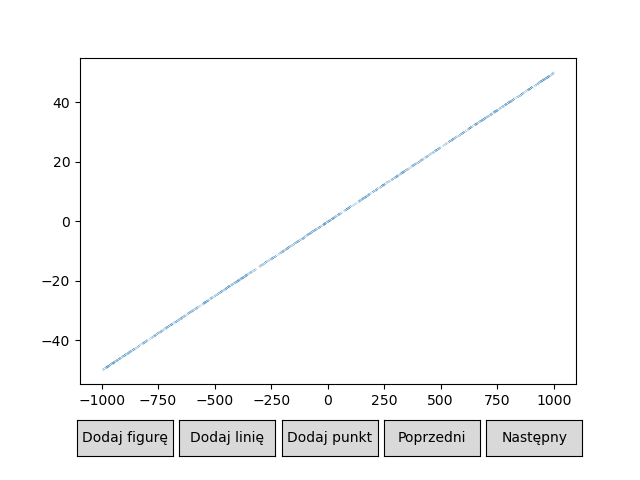

In [96]:
plot_d = Plot(points = [PointsCollection(points_d, s=.01)])
plot_d.draw()

## 3. Podziały punktów względem orientacji w stosunku do odcinka ab

In [55]:
def orientation(points, tolerance):
    # sortuje punkty ze względu na sposób wyznaczania wyznacznika oraz
    # orientacje względem prostej ab
    # [determinant_num][orientation]
    
    sorted_points = [[[] for _ in range(3)] for _ in range(4)]
    markings = [[None for _ in range(len(points))] for _ in range(4)]
    

    for j, c in enumerate(points):
        # tworzenie macierzy z punktów a, b, c
        m_2x2 = np.array([[a[0] - c[0], a[1] - c[1]],
                               [b[0] - c[0], b[1] - c[1]]])
        
        m_3x3 = np.array([[a[0], a[1], 1],
                               [b[0], b[1], 1],
                               [c[0], c[1], 1]])
        
        determinants = [det2x2(a, b, c), np.linalg.det(m_2x2), det3x3(a, b, c), np.linalg.det(m_3x3)]
        
        for i in range(4):
            if abs(determinants[i]) < tolerance:
                sorted_points[i][2].append(c)
                markings[i][j] = 2
            elif determinants[i] < 0:
                sorted_points[i][1].append(c)
                markings[i][j] = 1
            else:
                sorted_points[i][0].append(c)
                markings[i][j] = 0

    return sorted_points, markings

def show_result(points):
            plot = Plot(points = [PointsCollection(points[0], s=.1, c='b'), PointsCollection(points[1], s=.1, c='g'), PointsCollection(points[2], s=.5, c='r')])
            plot.draw()
            print(f'Left: {len(points[0])}\tRight: {len(points[1])}\tOn: {len(points[2])}')
    

def differences(points, markings_1, markings_2):
    # wyznacza różniące się punkty i zwraca je jako liste
    n = len(markings_1)
    diff_points = []

    for i in range(n):
        if markings_1[i] != markings_2[i]:
            diff_points.append(points[i])

    return diff_points

def show_differences(points, markings_1, markings_2):
    diff = differences(points, markings_1, markings_2)
    diff_plot = Plot(points=[PointsCollection(diff, c='r', s=5)])
    diff_plot.draw()
    print(f'Liczba różniących się punktów: {len(diff)}')
    
def count_points(markings):
    # funkcja zliczajaca punkty ze wzgledu na orientacje wzgledem prostej
    left, right, on = 0, 0, 0
    for i in range(len(markings)):
        if markings[i] == 0:
            left += 1
        elif markings[i] == 1:
            right += 1
        elif markings[i] == 2:
            on += 1
            
    return left, right, on

def create_table(dataset):
    # funcja wyświetlająca zbiórczą tabele o punktach z danego zbioru punktów
    all_markings = [dataset[i][1] for i in range(3)]
    data = [[] for _ in range(12)]
    k = 0
    for i in range(3):
        for j in range(4):
            l, r, o = count_points(all_markings[i][j])
            data[k] = [l, r, o]
            k += 1

    df = pd.DataFrame(data, index=pd.MultiIndex.from_product([['0', '1E-12', '1E-9'], ['2x2 własny', '2x2 numpy', '3x3 wlasny', '3x3 numpy']], names=['Tolerancja', 'Wyznacznik']),
                     columns=pd.Index(['na lewo', 'na prawo', 'na lini']))
    display(df)
    

### Podział punktów ze zbioru 1. z tolerancją = 0

In [97]:
a_dataset = [orientation(points_a, tolerance) for tolerance in [0, 10**(-12), 10**(-9)]]
sorted_points, markings = a_dataset[0]

#### Wyznacznik macierzy 2x2, implementacja własna

<IPython.core.display.Javascript object>


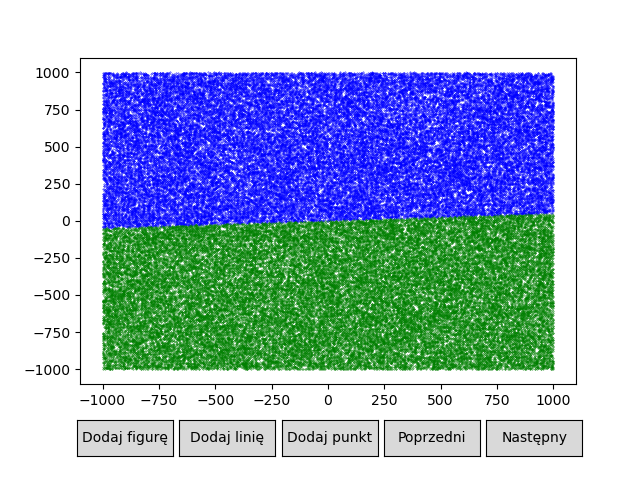

Left: 50086	Right: 49914	On: 0


In [98]:
show_result(sorted_points[0])

#### Wyznacznik 2x2, implementacja numpy

<IPython.core.display.Javascript object>


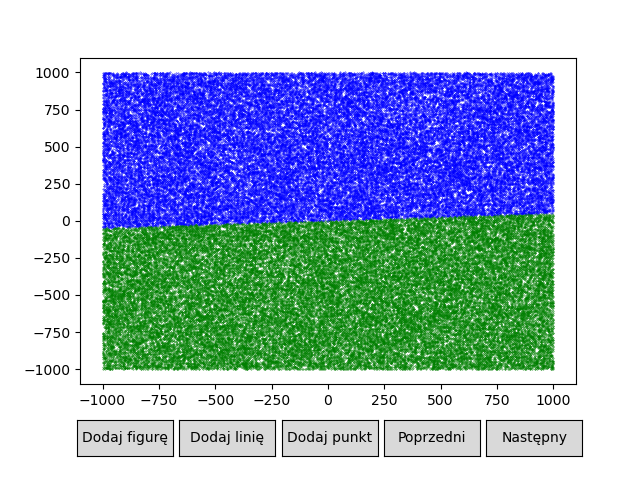

Left: 50086	Right: 49914	On: 0


In [99]:
show_result(sorted_points[1])

#### Wyznacznik macierzy 3x3, implementacja własna

<IPython.core.display.Javascript object>


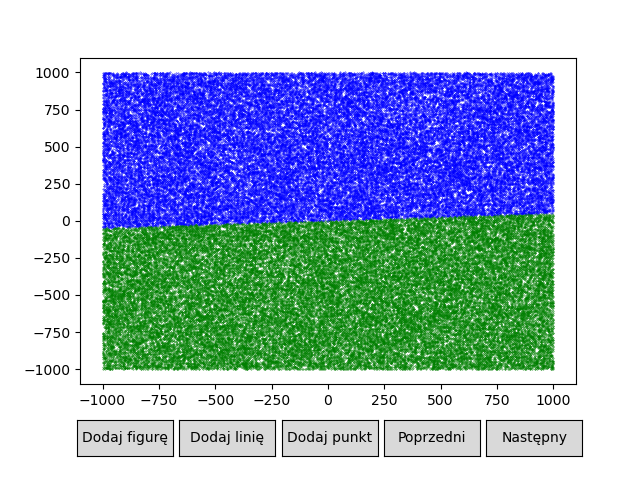

Left: 50086	Right: 49914	On: 0


In [100]:
show_result(sorted_points[2])

#### Wyznacznik macierzy 3x3, implementacja numpy

<IPython.core.display.Javascript object>


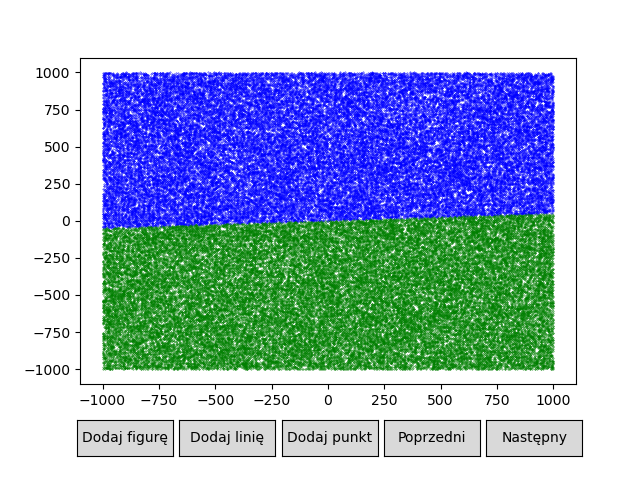

Left: 50086	Right: 49914	On: 0


In [101]:
show_result(sorted_points[3])

### Tabela dla punktów z podpunktu a)

In [102]:
create_table(a_dataset)

na lewo  na prawo  na lini
Tolerancja Wyznacznik                            
0          2x2 własny    50086     49914        0
           2x2 numpy     50086     49914        0
           3x3 wlasny    50086     49914        0
           3x3 numpy     50086     49914        0
1E-12      2x2 własny    50086     49914        0
           2x2 numpy     50086     49914        0
           3x3 wlasny    50086     49914        0
           3x3 numpy     50086     49914        0
1E-9       2x2 własny    50086     49914        0
           2x2 numpy     50086     49914        0
           3x3 wlasny    50086     49914        0
           3x3 numpy     50086     49914        0

### Podział punktów ze zbioru 2. z tolerancją = 0

In [103]:
b_dataset = [orientation(points_b, tolerance) for tolerance in [0, 10**(-12), 10**(-9)]]
sorted_points, markings = b_dataset[0]

#### Wyznacznik macierzy 2x2, implementacja własna

<IPython.core.display.Javascript object>


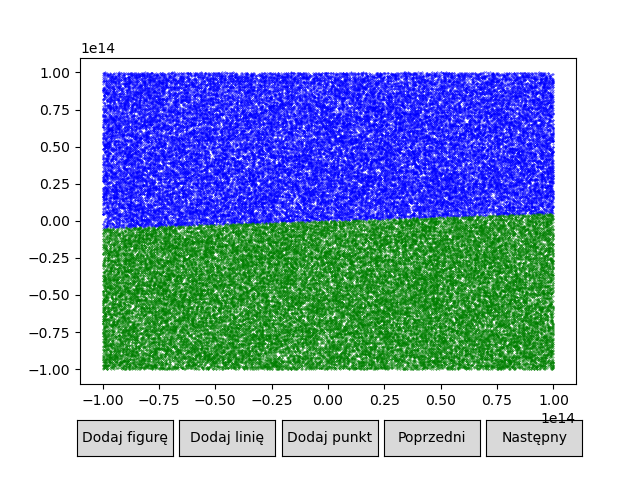

Left: 50018	Right: 49982	On: 0


In [104]:
show_result(sorted_points[0])

#### Wyznacznik macierzy 2x2, implementacja numpy

<IPython.core.display.Javascript object>


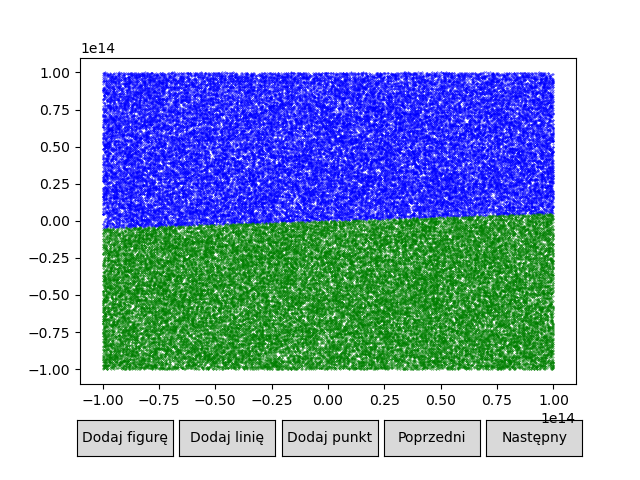

Left: 50016	Right: 49984	On: 0


In [105]:
show_result(sorted_points[1])

#### Wyznacznik macierzy 3x3, implementacja własna

<IPython.core.display.Javascript object>


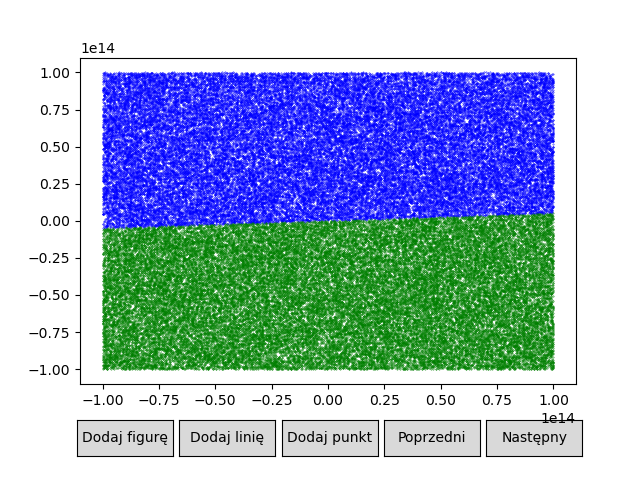

Left: 50013	Right: 49987	On: 0


In [106]:
show_result(sorted_points[2])

#### Wyznacznik macierzy 3x3, implementacja numpy

<IPython.core.display.Javascript object>


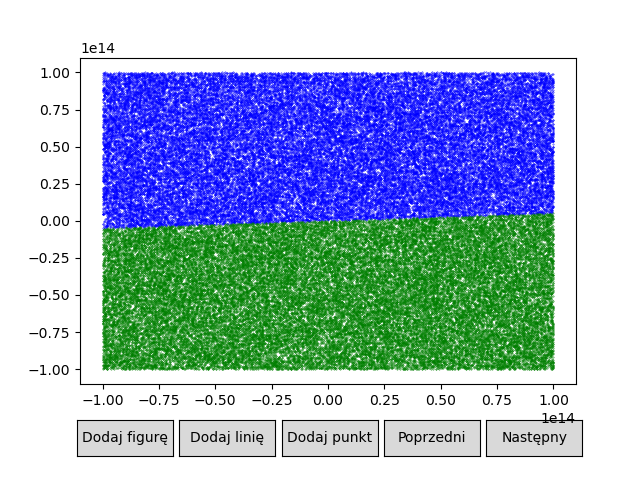

Left: 50013	Right: 49987	On: 0


In [107]:
show_result(sorted_points[3])


### Różnice ze względu na obliczanie wyznacznika macierzy:

#### - 2x2 własna i 2x2 numpy

<IPython.core.display.Javascript object>


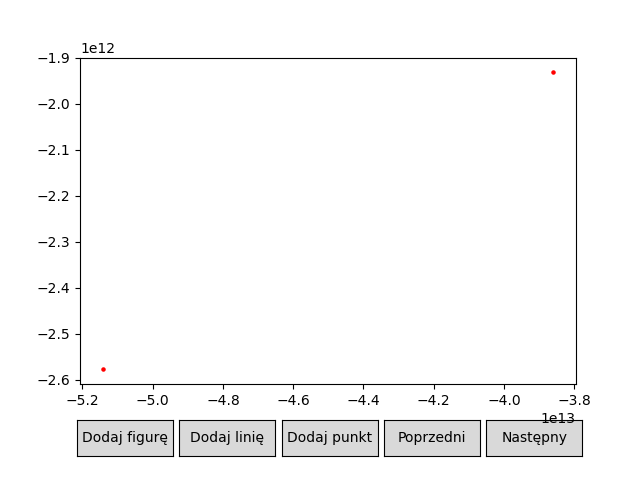

Liczba różniących się punktów: 2


In [108]:
show_differences(points_b, markings[0], markings[1])

#### -3x3  własna i 3x3 numpy

<IPython.core.display.Javascript object>


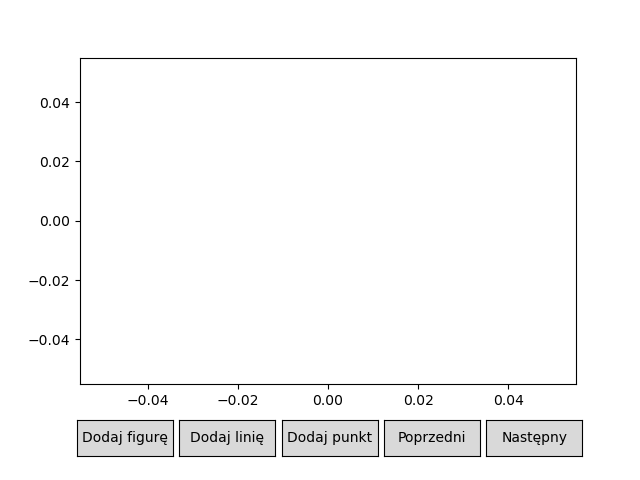

Liczba różniących się punktów: 0


In [109]:
show_differences(points_b, markings[2], markings[3])

#### - 2x2 własna i 3x3 własna

<IPython.core.display.Javascript object>


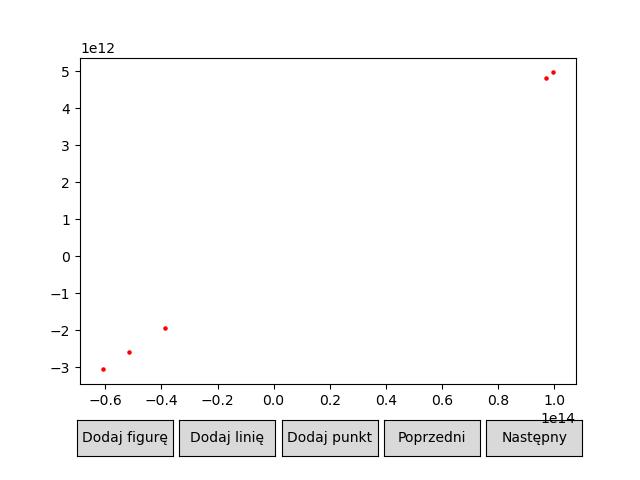

Liczba różniących się punktów: 5


In [110]:
show_differences(points_b, markings[0], markings[2])

#### - 2x2 numpy i 3x3 numpy

<IPython.core.display.Javascript object>


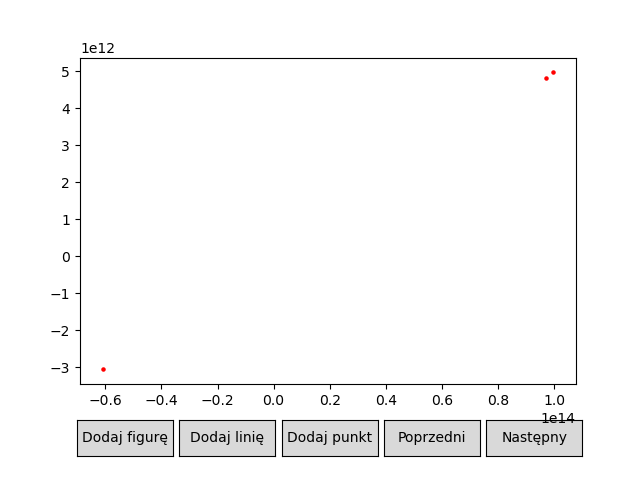

Liczba różniących się punktów: 3


In [111]:
show_differences(points_b, markings[1], markings[3])

### Tabela dla punktów z podpunktu b)

In [112]:
create_table(b_dataset)

na lewo  na prawo  na lini
Tolerancja Wyznacznik                            
0          2x2 własny    50018     49982        0
           2x2 numpy     50016     49984        0
           3x3 wlasny    50013     49987        0
           3x3 numpy     50013     49987        0
1E-12      2x2 własny    50009     49982        9
           2x2 numpy     50016     49984        0
           3x3 wlasny    50013     49987        0
           3x3 numpy     50013     49987        0
1E-9       2x2 własny    50009     49982        9
           2x2 numpy     50016     49984        0
           3x3 wlasny    50013     49987        0
           3x3 numpy     50013     49987        0

### Podział punktów ze zbioru 3. z tolerancją = 0

In [113]:
c_dataset = [orientation(points_c, tolerance) for tolerance in [0, 10**(-12), 10**(-9)]]
sorted_points, markings = c_dataset[0]

#### Wyznacznik macierzy 2x2, implementacja numpy

<IPython.core.display.Javascript object>


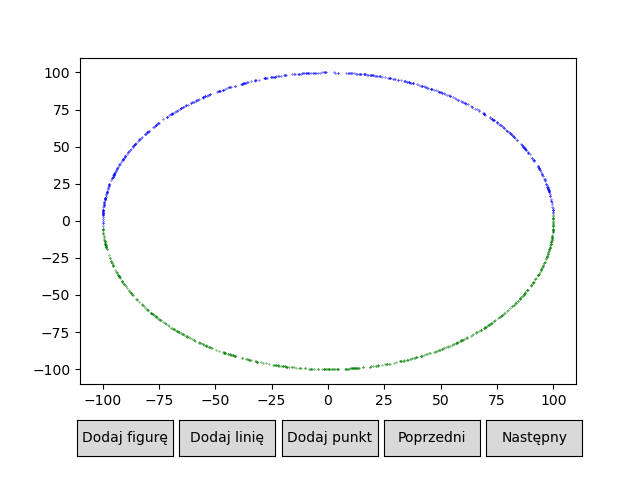

Left: 483	Right: 517	On: 0


In [114]:
show_result(sorted_points[0])

#### Wyznacznik macierzy 2x2, implementacja własna

<IPython.core.display.Javascript object>


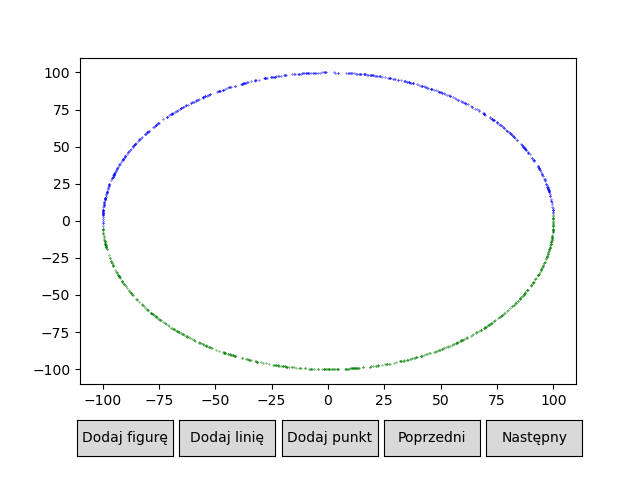

Left: 483	Right: 517	On: 0


In [115]:
show_result(sorted_points[1])

#### Wyznacznik macierzy 3x3, implementacja własna

<IPython.core.display.Javascript object>


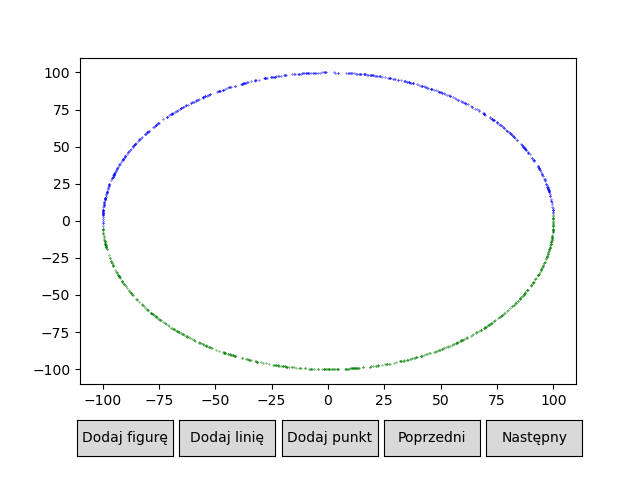

Left: 483	Right: 517	On: 0


In [116]:
show_result(sorted_points[2])

#### Wyznacznik macierzy 3x3, implementacja numpy

<IPython.core.display.Javascript object>


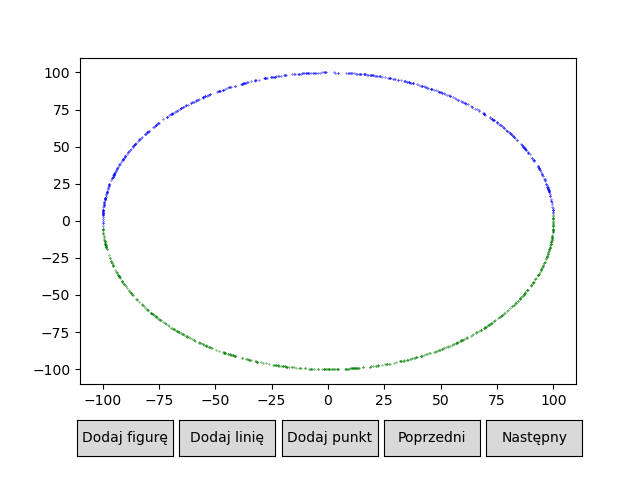

Left: 483	Right: 517	On: 0


In [117]:
show_result(sorted_points[3])

### Tabela dla punktów z podpunktu c)

In [118]:
create_table(c_dataset)

na lewo  na prawo  na lini
Tolerancja Wyznacznik                            
0          2x2 własny      483       517        0
           2x2 numpy       483       517        0
           3x3 wlasny      483       517        0
           3x3 numpy       483       517        0
1E-12      2x2 własny      483       517        0
           2x2 numpy       483       517        0
           3x3 wlasny      483       517        0
           3x3 numpy       483       517        0
1E-9       2x2 własny      483       517        0
           2x2 numpy       483       517        0
           3x3 wlasny      483       517        0
           3x3 numpy       483       517        0

### Podział punktów ze zbioru 4. z tolerancją = 0

In [119]:
d_dataset = [orientation(points_d, tolerance) for tolerance in [0, 10**(-12), 10**(-9)]]
sorted_points, markings = d_dataset[0]

#### Wyznacznik macierzy 2x2, implementacja własna

<IPython.core.display.Javascript object>


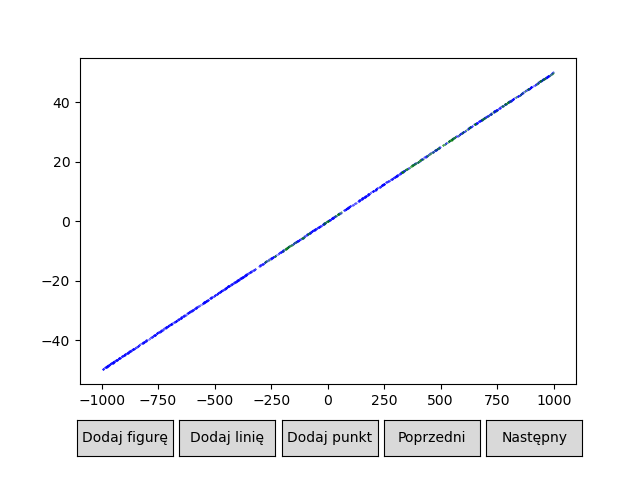

Left: 864	Right: 136	On: 0


In [120]:
show_result(sorted_points[0])

#### Wyznacznik macierzy 2x2, implementacja numpy

<IPython.core.display.Javascript object>


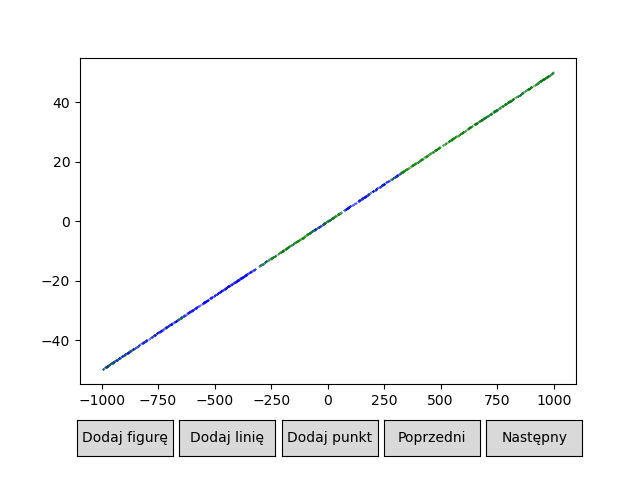

Left: 515	Right: 485	On: 0


In [121]:
show_result(sorted_points[1])

#### Wyznacznik macierzy 3x3, implementacja własna

<IPython.core.display.Javascript object>


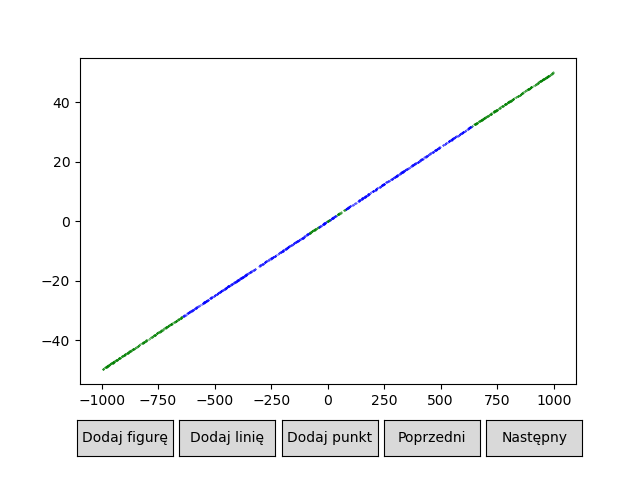

Left: 578	Right: 422	On: 0


In [122]:
show_result(sorted_points[2])

#### Wyznacznik macierzy 3x3, implementacja numpy

<IPython.core.display.Javascript object>


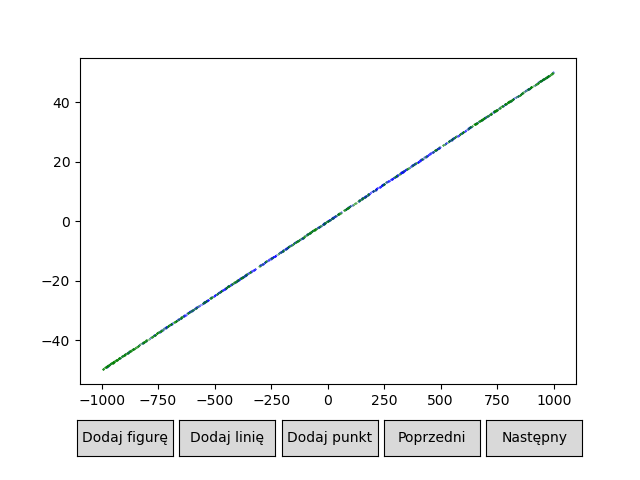

Left: 478	Right: 522	On: 0


In [123]:
show_result(sorted_points[3])

### Różnice ze względu na obliczanie wyznacznika macierzy:

#### - 2x2 własna i 2x2 numpy

<IPython.core.display.Javascript object>


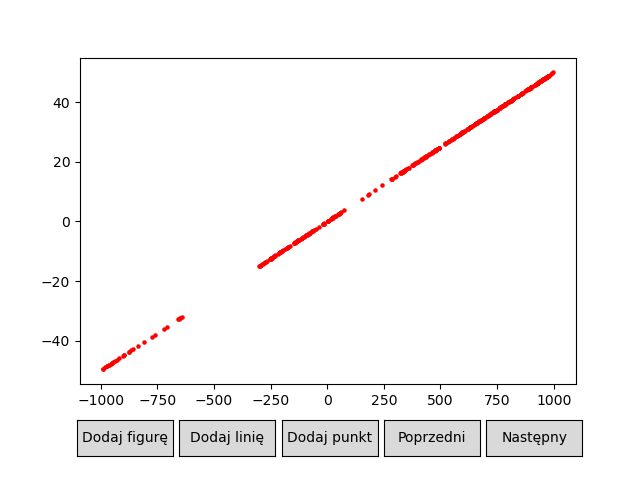

Liczba różniących się punktów: 371


In [124]:
show_differences(points_d, markings[0], markings[1])

#### - 3x3 własna i  3x3 numpy

<IPython.core.display.Javascript object>


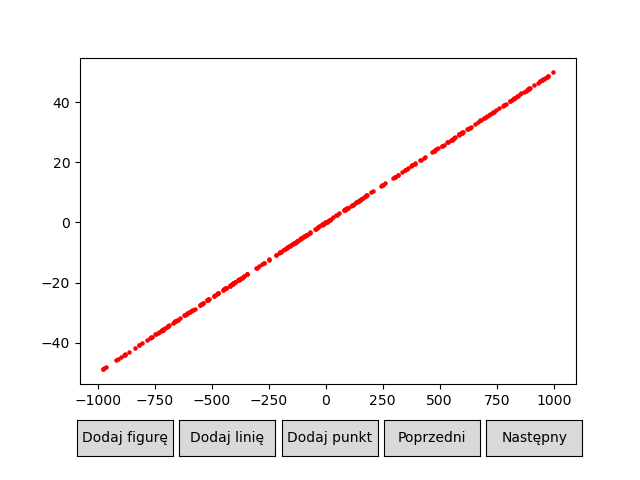

Liczba różniących się punktów: 310


In [125]:
show_differences(points_d, markings[2], markings[3])

#### - 2x2 własna i 3x3 własna

<IPython.core.display.Javascript object>


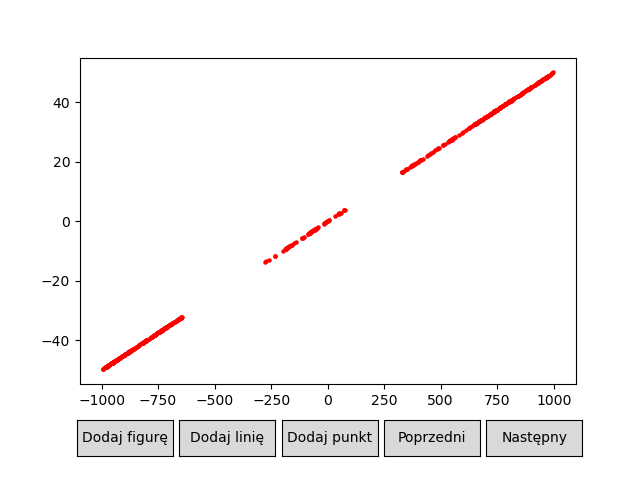

Liczba różniących się punktów: 462


In [126]:
show_differences(points_d, markings[0], markings[2])

### - 2x2 numpy i 3x3 numpy

<IPython.core.display.Javascript object>


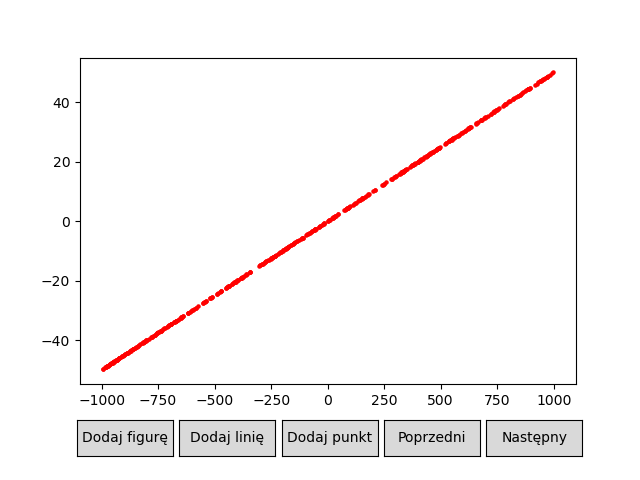

Liczba różniących się punktów: 497


In [127]:
show_differences(points_d, markings[1], markings[3])

### Podział punktów ze zbioru 4. z tolerancją = E1-12

In [128]:
sorted_points, markings = d_dataset[1]

#### Wyznacznik macierzy 2x2, implementacja własna

<IPython.core.display.Javascript object>


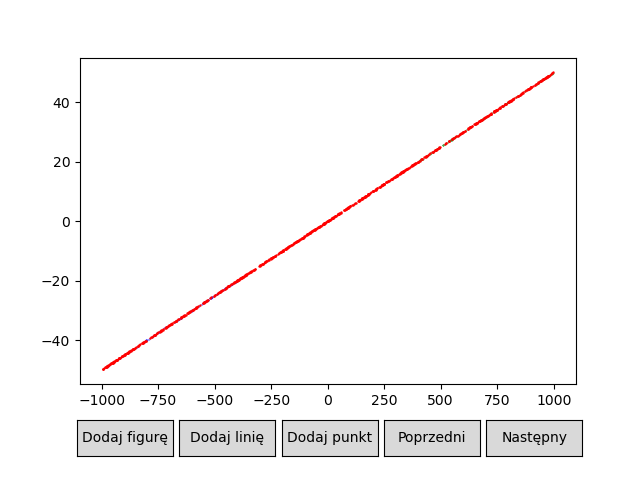

Left: 73	Right: 75	On: 852


In [129]:
show_result(sorted_points[0])

#### Wyznacznik macierzy 2x2, implementacja numpy

<IPython.core.display.Javascript object>


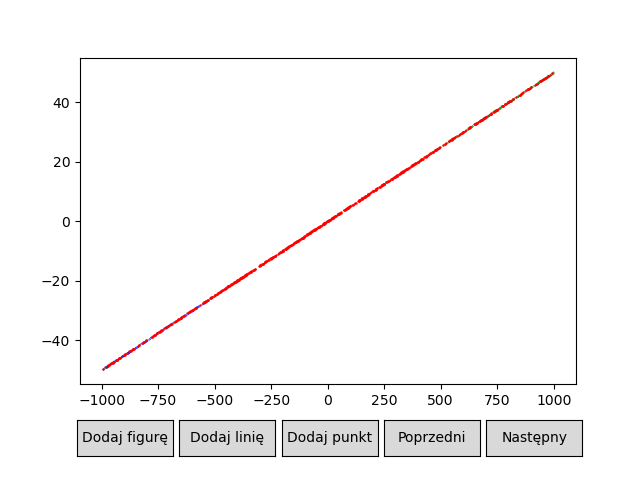

Left: 137	Right: 144	On: 719


In [130]:
show_result(sorted_points[1])

#### Wyznacznik macierzy 3x3, implementacja własna

<IPython.core.display.Javascript object>


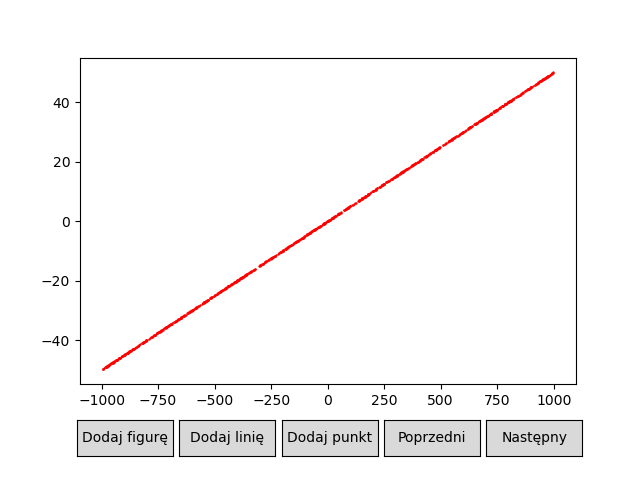

Left: 0	Right: 0	On: 1000


In [131]:
show_result(sorted_points[2])

#### Wyznacznik macierzy 3x3, implementacja numpy

<IPython.core.display.Javascript object>


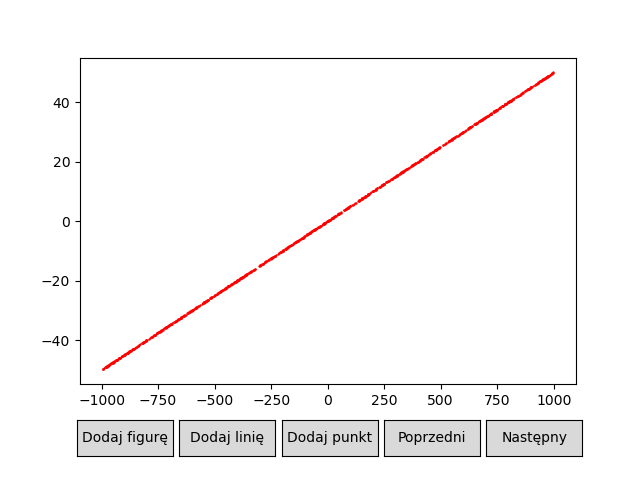

Left: 0	Right: 0	On: 1000


In [132]:
show_result(sorted_points[3])

### Tabela dla punktów z podpunktu d)

In [92]:
create_table(d_dataset)

na lewo  na prawo  na lini
Tolerancja Wyznacznik                            
0          2x2 własny      864       136        0
           2x2 numpy       515       485        0
           3x3 wlasny      578       422        0
           3x3 numpy       478       522        0
1E-12      2x2 własny       73        75      852
           2x2 numpy       137       144      719
           3x3 wlasny        0         0     1000
           3x3 numpy         0         0     1000
1E-9       2x2 własny        0         0     1000
           2x2 numpy         0         0     1000
           3x3 wlasny        0         0     1000
           3x3 numpy         0         0     1000